# File acquisition

In this notebeook, I will lay out the main ways that I will be interacting with the data, building custom functions to read in the brain and stimulus data subject by subject.

## Goals
* Read in fMRI data
    * the fmriprep files
    * spm roi files
    * freesurfer files 
    * anatomical mask file
* Read in stimuli presentation lists
* Load images

In [1]:
from packages import *
%matplotlib inline

In [2]:
import imageio
from nilearn.image.image import mean_img

### Loading the brain scan images

To load and work with the fMRI scan files as well as processed derivatives, I will be using nibabel. 

In [3]:
def get_spm_images(spm_dir, requests):
    output = {}
    files = os.listdir(spm_dir)
    if requests == '*':
        for file in files:
            s = file[file.find('mask-')+5:file.find('.')]
            output[s] = load_file(os.path.join(spm_dir, file))[0]
    else:
        for file in files:
            for req in requests:
                if '-' + req in file:
                    output[req] = load_file(os.path.join(spm_dir, file))[0]          
    return output

In [4]:
def get_roi_images(roi_dir, requests):
    output = {}
    roi_dir = os.path.join(roi_dir, 'h5')
    files = os.listdir(roi_dir)
    for file in files:
        for req in requests:
            if 'TR' + req + '.' in file:
                output[req] = load_file(os.path.join(roi_dir, file))[0]          
    return output

In [5]:
def get_fmriprep_images(fmriprep_dir, requests):
    output = {}
    for ses in SESSIONS:
        output[ses] = session = {}
        ses_dir = os.path.join(fmriprep_dir, get_session_dir(ses), 'func')
        files = os.listdir(ses_dir)
        for file in files:
            if 'localizer' in file:
                continue
            for req in requests:
                if '-' + req in file or '_' + req in file:
                    run = extract_run(file)
                    if run not in session:
                        session[run] = {}
                    session[run][req] = load_file(os.path.join(ses_dir, file))[0]          
    return output

In [6]:
def get_subject_images(subject, data_dir, anat_image=False, fmri_prep_reqs=None, freesurfer_reqs=None, spm_reqs =None,
                      roi_reqs=None):
    images = {}
    sub_dir = {}
    for key in ['fmriprep', 'freesurfer', 'spm', 'roi']:
        sub_dir[key] = os.path.join(data_dir, 'fmri', key, get_subject_dir(subject))
    if fmri_prep_reqs:
        images['fmriprep'] = get_fmriprep_images(sub_dir['fmriprep'], set(fmri_prep_reqs))
#     if freesurfer_reqs:
#         images['freesurfer'] = get_freesurfer_images(sub_dir['freesurfer'], set(freesurfer_reqs))
    if spm_reqs:
        images['spm'] = get_spm_images(sub_dir['spm'], spm_reqs)
    if roi_reqs:
        images['roi'] = get_roi_images(sub_dir['roi'], roi_reqs)
    if anat_image:
        anat_dir = os.path.join(sub_dir['fmriprep'], 'anat')
        images['anat'] = {}
        f_mask = '{}_T1w_brainmask.nii.gz'.format(get_subject_dir(subject)[:-1])
        f_preproc ='{}_T1w_preproc.nii.gz'.format(get_subject_dir(subject)[:-1])
        images['anat']['brainmask'] = load_file(os.path.join(anat_dir, f_mask))[0]
        images['anat']['preproc'] = load_file(os.path.join(anat_dir, f_preproc))[0]
    return images

In [32]:
images_1 = get_subject_images(subject=1, data_dir=DATA_DIR, anat_image=True, 
                              fmri_prep_reqs=set(['preproc', 'brainmask', 'confounds']), spm_reqs='*')
images_2 = get_subject_images(subject=2, data_dir=DATA_DIR, anat_image=True, 
                              fmri_prep_reqs=set(['preproc', 'brainmask', 'confounds']), spm_reqs='*')
images_3 = get_subject_images(subject=3, data_dir=DATA_DIR, anat_image=True, 
                              fmri_prep_reqs=set(['preproc', 'brainmask', 'confounds']), spm_reqs='*')

### Loading the stimulus presentation lists

These files will enable me to link the brain data and the visual stimulus

In [7]:
def load_stim_list(subject, data_dir):
    stim_list = {}
    sub_dir = os.path.join(data_dir, 'stimulus', 'presentation', get_subject_dir(subject))
    for ses in SESSIONS:
        stim_list[ses] = {}
        ses_dir = os.path.join(sub_dir, get_session_dir(ses))
        files = os.listdir(ses_dir)
        for f in files:
            if 'run' not in f:
                continue
            i = f.find('run')
            run = int(f[i+3:i+5])
            with open(os.path.join(ses_dir, f), 'r') as f:
                lines = [l.strip() for l in f.readlines()]
            stim_list[ses][run] = lines
    return stim_list

In [8]:
stim_1 = load_stim_list(1, DATA_DIR)
stim_2 = load_stim_list(2, DATA_DIR)
stim_3 = load_stim_list(3, DATA_DIR)

In [9]:
stim_1[9][5]

['rep_n04335435_10063.JPEG',
 'n04136333_1993.JPEG',
 'n03840681_10401.JPEG',
 'n07871810_13696.JPEG',
 'COCO_train2014_000000232648.jpg',
 'recordingstudio1.jpg',
 'COCO_train2014_000000247121.jpg',
 'rep_n04136333_2487.JPEG',
 'n02114855_10373.JPEG',
 'n02489166_14224.JPEG',
 'COCO_train2014_000000556491.jpg',
 'n03954731_51515.JPEG',
 'ballroom1.jpg',
 'attic3.jpg',
 'COCO_train2014_000000388011.jpg',
 'n02978881_8333.JPEG',
 'COCO_train2014_000000492402.jpg',
 'n02641379_26845.JPEG',
 'COCO_train2014_000000122811.jpg',
 'forestpath10.jpg',
 'weightroom6.jpg',
 'COCO_train2014_000000495243.jpg',
 'n02966193_16898.JPEG',
 'COCO_train2014_000000356771.jpg',
 'n04371774_728.JPEG',
 'n03529860_9840.JPEG',
 'COCO_train2014_000000447457.jpg',
 'n03000247_27870.JPEG',
 'COCO_train2014_000000549301.jpg',
 'COCO_train2014_000000525668.jpg',
 'COCO_train2014_000000001308.jpg',
 'rep_COCO_train2014_000000199743.jpg',
 'gasstation7.jpg',
 'track.jpg',
 'COCO_train2014_000000273120.jpg',
 'COCO_

### Finally, we will need to load the photos (as numpy arrays).

In [10]:
ex = 'n03180011_6063.JPEG'

In [11]:
def load_photo(data_dir, filename):
    stim_dir = os.path.join(data_dir, 'stimulus', 'img')
    if filename[:4] == 'rep_':
        filename = filename[4:]
    coco, imagenet, scene = 0, 1, 2
    if 'COCO' == filename[:4]:
        filetype = coco
        stim_dir = os.path.join(stim_dir, 'COCO')
    elif 'n0' == filename[:2] or 'n1' == filename[:2]:
        filetype = imagenet
        stim_dir = os.path.join(stim_dir, 'ImageNet')
    else:
        filetype = scene
        stim_dir = os.path.join(stim_dir, 'Scene')
    img = imageio.imread(os.path.join(stim_dir, filename))
    return np.asarray(img)

In [12]:
img = load_photo(DATA_DIR, ex)

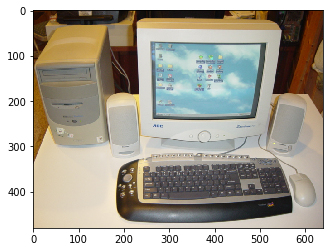

In [13]:
plt.imshow(img)

### Inspecting *..bold_space-T1w_preproc.nii.gz*

These files contain timeseries data of participants responses to visual stimulus

In [14]:
ex_1 = images_1['fmriprep'][1][1]['preproc']
ex_2 = images_2['fmriprep'][1][1]['preproc']
ex_3 = images_3['fmriprep'][1][1]['preproc']

ex_1.shape, ex_2.shape, ex_3.shape

((71, 89, 72, 194), (72, 92, 70, 194), (72, 88, 67, 194))

The scans are 3-Dimensional in space, vary between subjects and contain 194 snapshots.

In [15]:
len(stim_1[1][1])

37

In each run, 37 images were presented and correspond to 5 snapshots.

In [16]:
194 - 37 * 5

9

First 3 and last 6 shots are buffers.

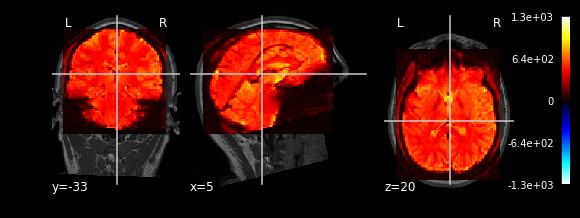

In [19]:
PLOTS['stat_map'](mean_img(ex_1), images_1['anat']['preproc'])